# Similar-Products

## Data PreProcessing

### 1. Importing Header Files 

In [1]:
import numpy as np
import pandas as pd
import os

### 2. Loading and understanding Data 

In [2]:
# Loading the Data
data = pd.read_json('tops_fashion.json')

In [3]:
# Shape of Data
print ('Number of Products : ', data.shape[0], \
       'Number of Features/Variables:', data.shape[1])

Number of Products :  183138 Number of Features/Variables: 19


In [4]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

Of these 19 features, we will be using only 7 features in our recommendation system including image url
1. asin  ( Amazon standard identification number)
2. brand ( brand to which the product belongs to)
3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes )
4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
5. medium_image_url  ( url of the image )
6. title (title of the product.)
7. formatted_price (price of the product)

In [5]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [6]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])

Number of data points :  183138 Number of features: 7


In [7]:
#viewing data
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


In [8]:
data.isnull().sum()

asin                      0
brand                   151
color                118182
medium_image_url          0
product_type_name         0
title                     0
formatted_price      154743
dtype: int64

In [9]:
data.describe()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
count,183138,182987,64956,183138,183138,183138,28395
unique,183138,10577,7380,170782,72,175985,3135
top,B0719NC9RP,Zago,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Nakoda Cotton Self Print Straight Kurti For Women,$19.99
freq,1,223,13207,23,167794,77,945


### 3.Removing Data rows with Null values in color and formatted price

In [10]:
data = data.loc[~data['formatted_price'].isnull()]
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating some Null rows :', data.shape[0])

Number of data points After eliminating some Null rows : 28385


### 4.Understanding and Removing Duplicates

In [11]:
print(sum(data.duplicated('title')))

2325


In [12]:
# Remove All products with short titles
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [13]:
#sorting the data alphabetically
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

C:\Users\YASH\.conda\envs\6.86x\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


In [14]:
data.to_pickle('preprocessed_data')

## Building Image based Recommender System

### 1. Importing Libraries

In [15]:
import tensorflow as tf
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os, os.path

### 2. Preprocessing of Trainning Set

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('images2/',
                                                 target_size = (224, 224),
                                                 batch_size = 1,
                                                 class_mode=None,
                                                 shuffle=False)

Found 16032 images belonging to 1 classes.


### 3. Building the model

In [17]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

### 4. Compiling the Model

In [18]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

### 5. Training the Model

In [ ]:
asins = []

for i in training_set.filenames:
    asins.append(i[2:-5])
    
features_train = model.predict(training_set, nb_train_samples // batch_size)
features_train = features_train.reshape((16032,25088))

#saving the data so that next time we don't have to train the time taking model
np.save(open('features.npy', 'wb'), features_train)
np.save(open('feature_asins.npy', 'wb'), np.array(asins))

### 6. Importing Necessary Files

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from IPython.display import display, Image

features_train = np.load('features.npy')
asins = np.load('feature_asins.npy')
asins = list(asins)


### 7. Getting Similar Product Images

In [20]:
def similar_products_images(product_index, num_of_similar_products):
    df_asins = list(data['asin'])
    product_index = asins.index(df_asins[product_index])
    pairwise_dist = pairwise_distances(features_train, features_train[product_index].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_of_similar_products]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_of_similar_products]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            

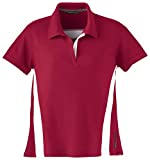

Product Title:  North End Sport Red 78616 Ladies' Polyester Pique Polo with Stripe - SPORT RED 807 - M
Euclidean Distance from input image: 4.862804e-06


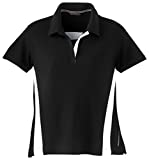

Product Title:  North End Sport Red 78616 Ladies' Polyester Pique Polo with Stripe - BLACK 703 - M
Euclidean Distance from input image: 30.529158


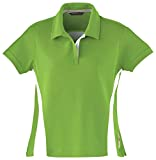

Product Title:  North End Sport Red 78616 Ladies' Polyester Pique Polo with Stripe - ACID GREEN 645 - M
Euclidean Distance from input image: 31.528242


In [21]:
similar_products_images(1200,3)

In [ ]:
#import pandas as pd
#data = pd.read_pickle('preprocessed_data')